# Deep Convolutional Generative Adversal Networks
_____


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
%matplotlib inline

sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

### データの読み込み

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

# 画像を読み込んだ時の変換関数を作る
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,),(0.5,))]) # [-1, 1] に規格化 t = (t - 0.5) / 0.5 を意味する演算
# それぞれのデータと読み込み方を指定
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                          shuffle=True, num_workers=2)


#### GPU が使えるなら使う

In [0]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

## Generator・Discriminator

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 偽画像を生成するモデル
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # ※ out_size = (in_size - 1)*stride - 2*padding + dilation*(kernel_size - 1) + output_padding + 1
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.z_dim, 64, kernel_size=4, bias=True),  # z_dim*1*1 -> 64*4*4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=4, padding=1, bias=True),  # 64*4*4 -> 32*8*8
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 8, stride=2, kernel_size=4, padding=2, bias=True),  # 32*8*8 -> 8*14*14
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, 1, stride=2, kernel_size=4, padding=1, bias=True),   # 8*14*14 -> 1*28*28
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.z_dim, 1, 1)  # batch_len*z_dim -> batch_len*z_dim*1*1
        return self.main(z)

# 偽画像かどうかを0, 1値(←Sigmoid関数にかけた後)で判別する関数
class Discriminator(nn.Module):
    def __init__(self, z_dim=None):
        super(Discriminator, self).__init__()
        # out_size = (in_size + 2*padding - dilation*(kernel_size - 1) - 1)//stride + 1
        self.main = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, bias=True),  # 1*28*28 -> 4*13*13
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4, 16, kernel_size=3, stride=2, bias=True),  # 4*13*13 -> 16*6*6
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=True),  # 16*6*6 -> 32*2*2
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 1, 1)  # 32*1*1 -> 1*1*1
        )

    def forward(self, x):
        x = self.main(x)
        return x.squeeze()

In [5]:
z_dim = 64
generator = nn.DataParallel(try_gpu(Generator(z_dim)))
discriminator = nn.DataParallel(try_gpu(Discriminator(z_dim)))

print(generator)
print(discriminator)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): ConvTranspose2d(32, 8, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): Tanh()
    )
  )
)
DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, 

In [0]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### モニター用の z

In [0]:
fix_z = try_gpu(torch.randn(10, z_dim))

### Generator と Discriminator を交互に学習

5 epoch  genloss: 82.6902985572815 disloss: 78.91053366661072


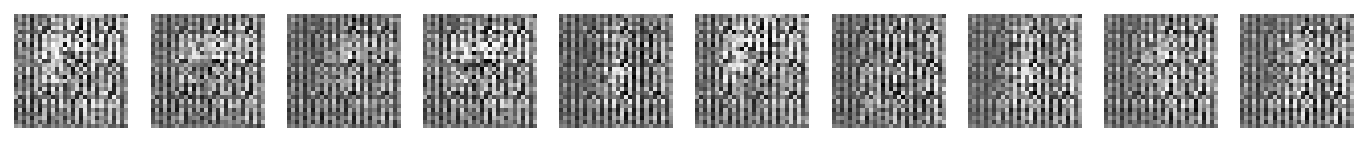

10 epoch  genloss: 81.81779873371124 disloss: 80.28983271121979


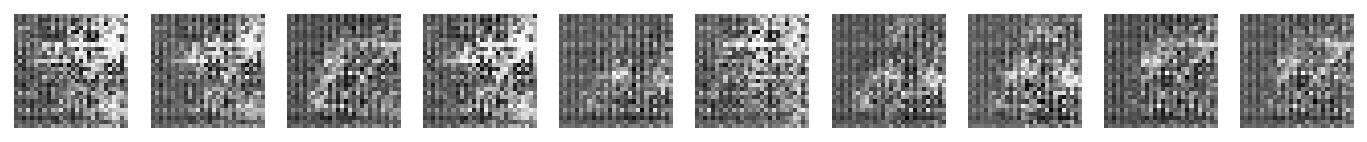

15 epoch  genloss: 84.80541479587555 disloss: 78.45265311002731


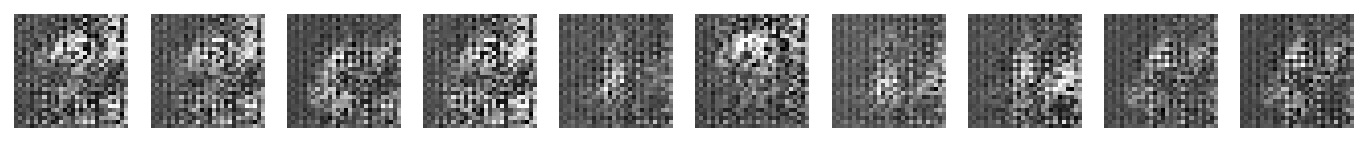

20 epoch  genloss: 90.093077480793 disloss: 74.85256201028824


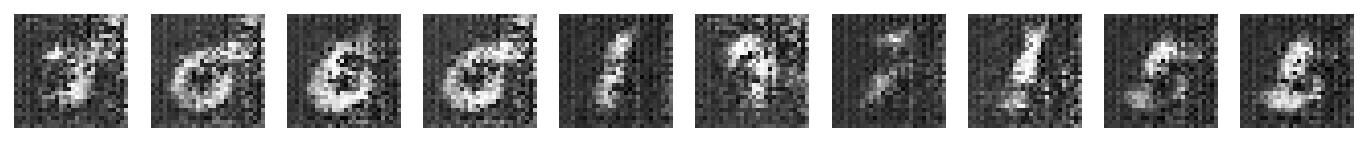

25 epoch  genloss: 91.97266960144043 disloss: 73.57523328065872


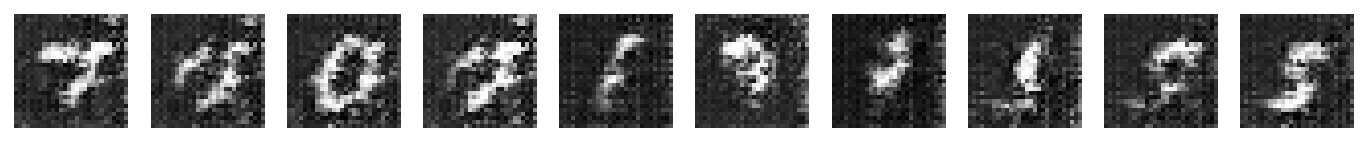

30 epoch  genloss: 95.06907498836517 disloss: 71.89310872554779


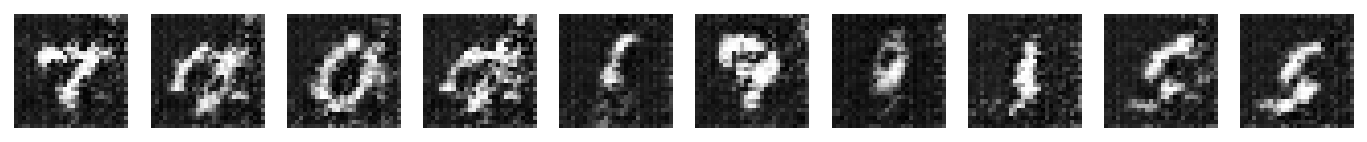

35 epoch  genloss: 96.76227289438248 disloss: 71.11480128765106


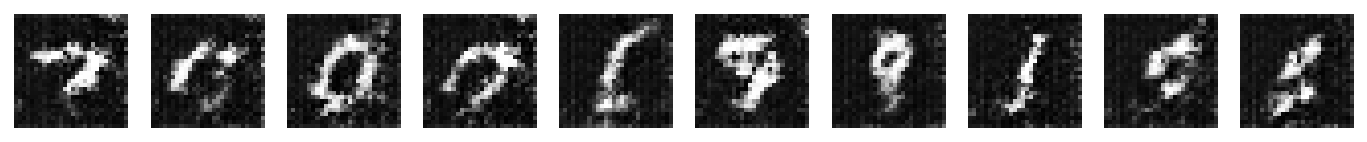

40 epoch  genloss: 97.20716047286987 disloss: 71.64049059152603


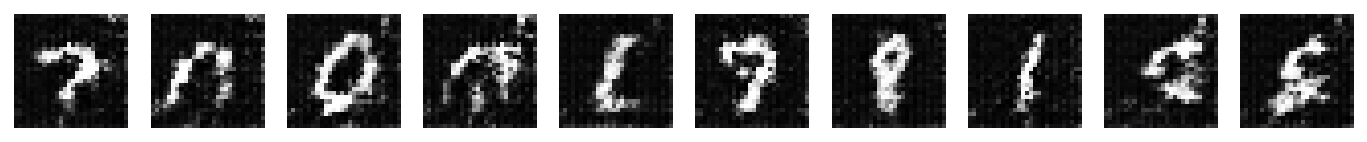

45 epoch  genloss: 95.66977936029434 disloss: 73.27260041236877


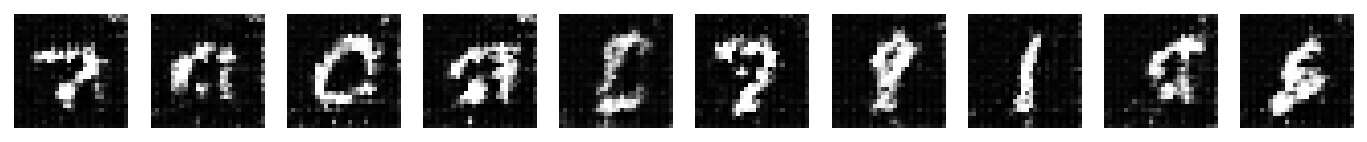

50 epoch  genloss: 94.31047332286835 disloss: 74.57416212558746


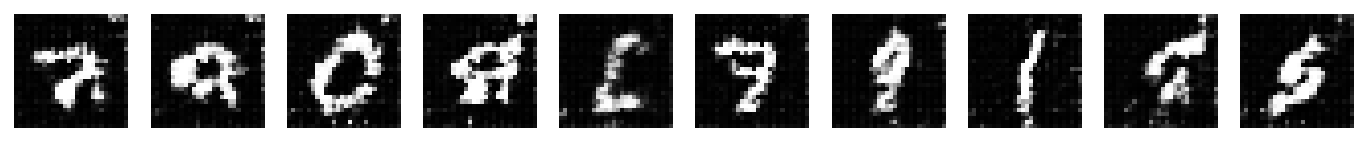

55 epoch  genloss: 92.59998768568039 disloss: 76.10115438699722


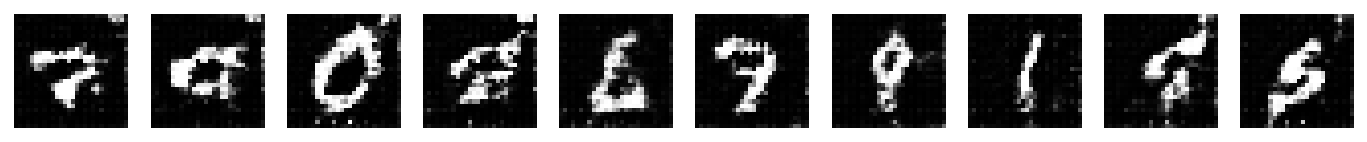

60 epoch  genloss: 91.65685701370239 disloss: 76.9955261349678


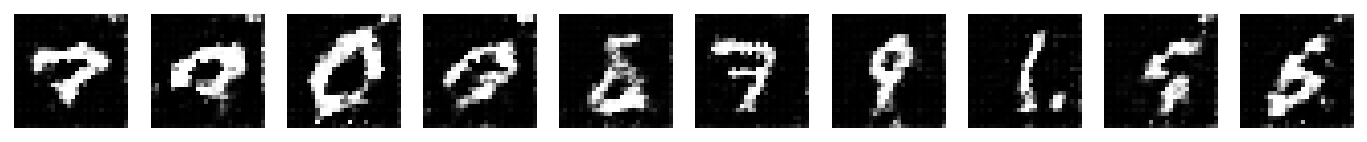

65 epoch  genloss: 90.72500020265579 disloss: 77.57034665346146


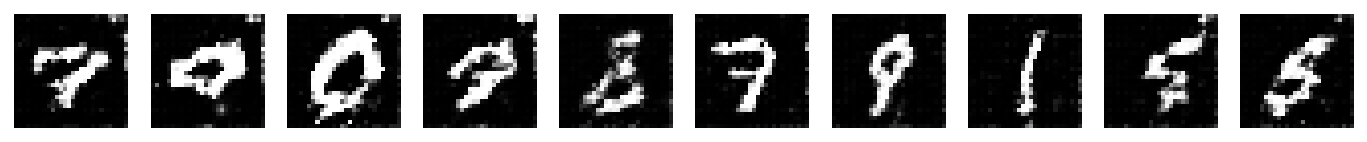

70 epoch  genloss: 90.57973945140839 disloss: 77.72600275278091


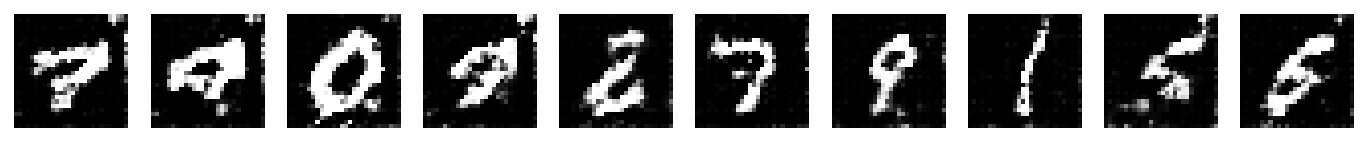

75 epoch  genloss: 89.9842819571495 disloss: 78.05217838287354


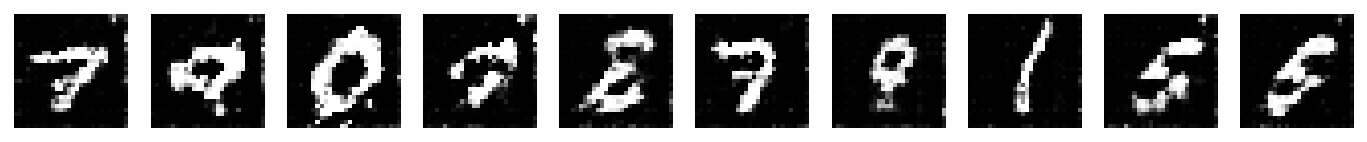

80 epoch  genloss: 90.0106326341629 disloss: 78.17329454421997


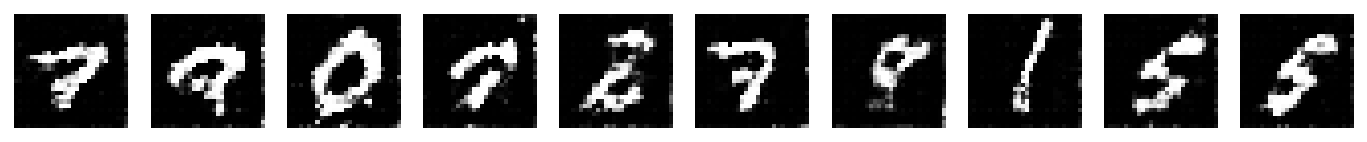

85 epoch  genloss: 89.70972037315369 disloss: 78.27624660730362


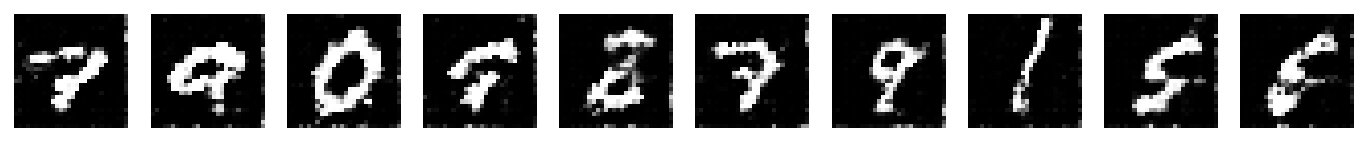

90 epoch  genloss: 89.0303121805191 disloss: 78.6748029589653


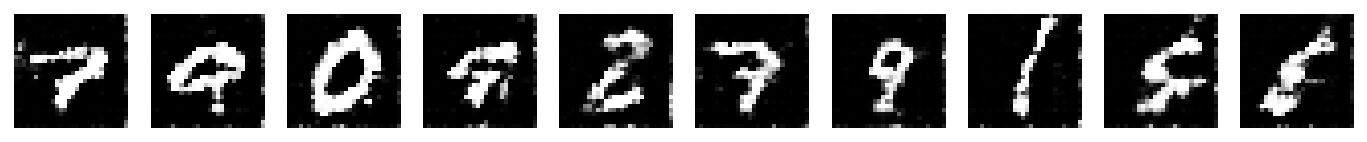

95 epoch  genloss: 88.88695031404495 disloss: 78.68781799077988


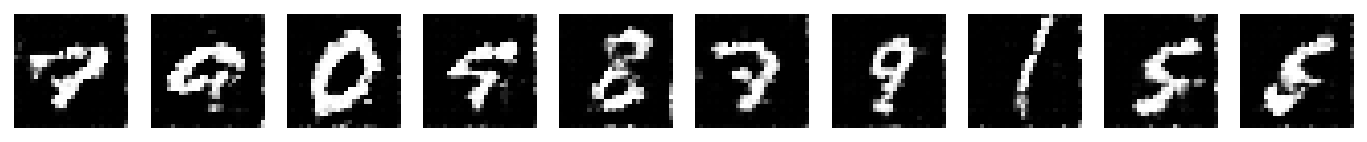

100 epoch  genloss: 88.72159737348557 disloss: 79.03390473127365


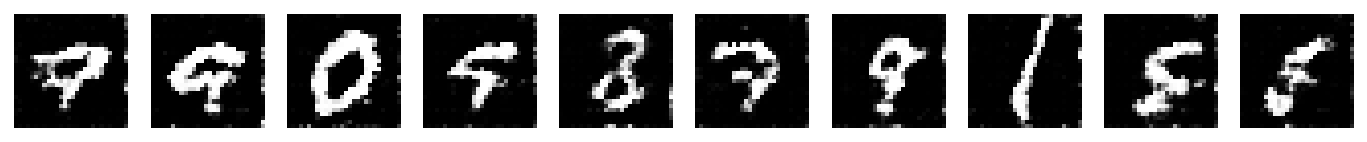

105 epoch  genloss: 88.26986020803452 disloss: 79.30907946825027


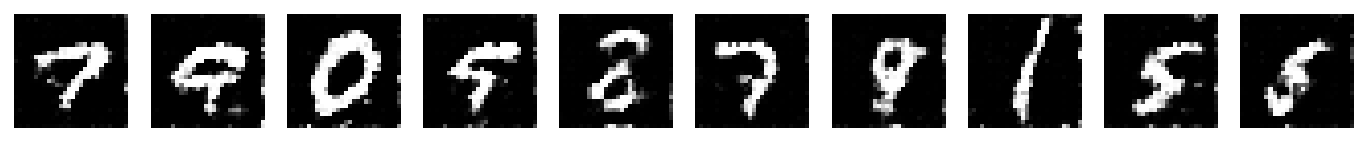

110 epoch  genloss: 88.13684839010239 disloss: 79.34264981746674


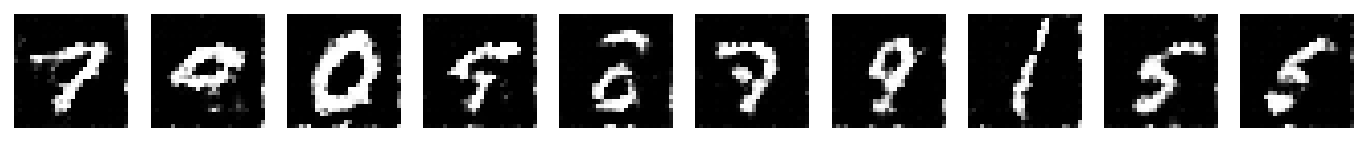

115 epoch  genloss: 88.03329735994339 disloss: 79.42917597293854


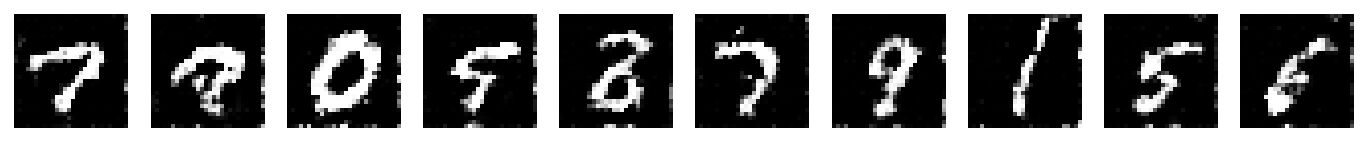

120 epoch  genloss: 87.53701186180115 disloss: 79.64186155796051


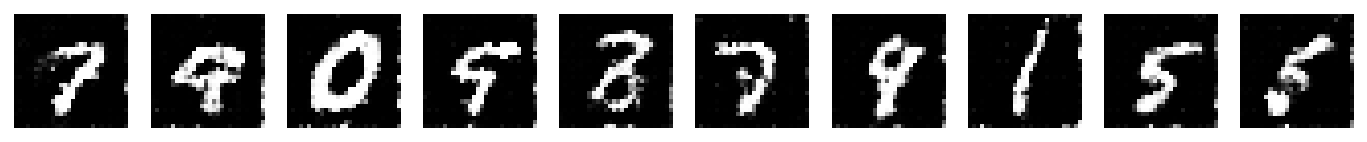

125 epoch  genloss: 87.26861184835434 disloss: 79.74498963356018


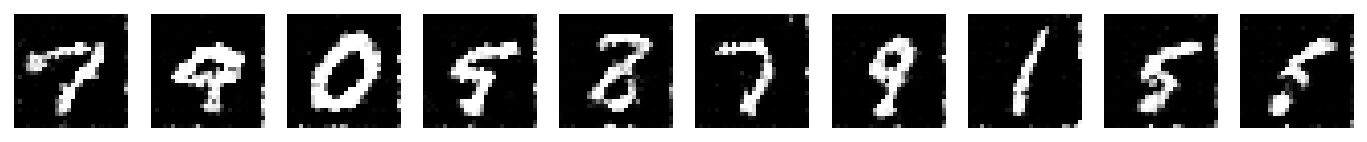

130 epoch  genloss: 87.40703910589218 disloss: 79.82893860340118


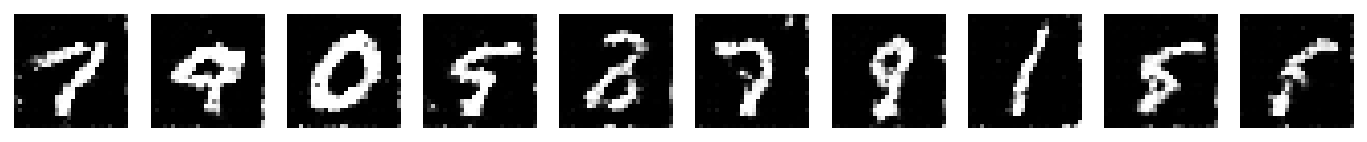

135 epoch  genloss: 87.09940373897552 disloss: 79.86492556333542


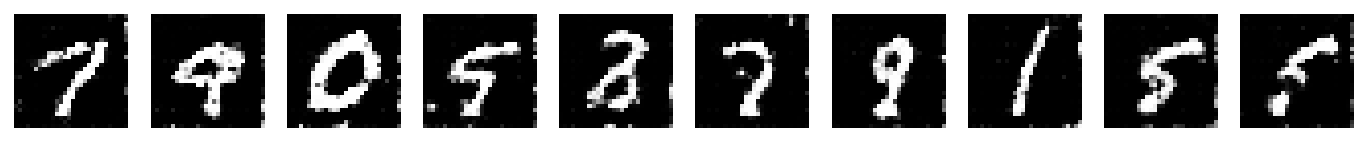

140 epoch  genloss: 87.00479507446289 disloss: 79.95077848434448


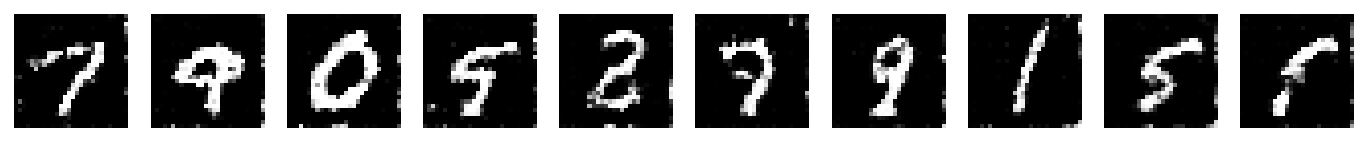

145 epoch  genloss: 87.09555208683014 disloss: 79.92973268032074


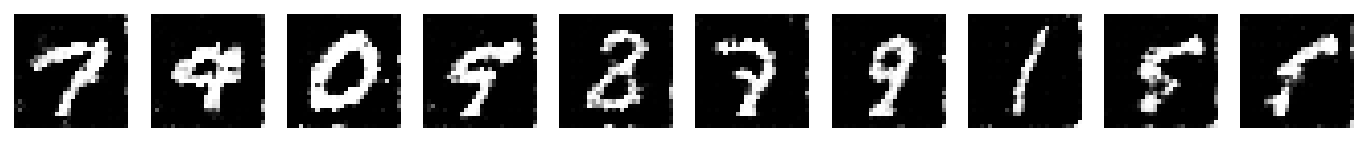

150 epoch  genloss: 87.00390666723251 disloss: 79.89108496904373


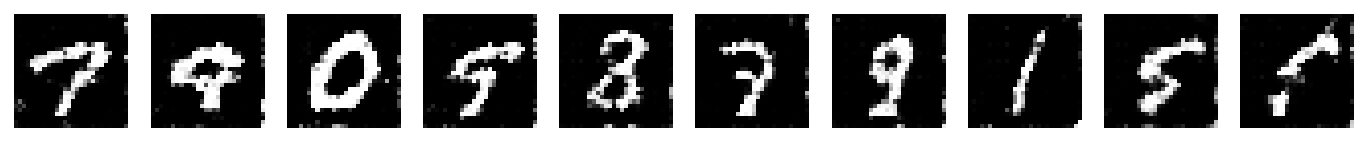

155 epoch  genloss: 87.12362426519394 disloss: 79.91615825891495


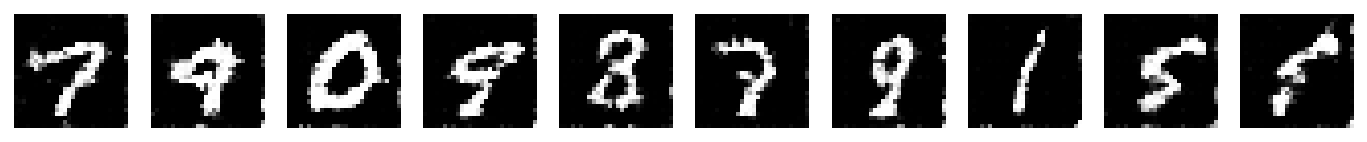

160 epoch  genloss: 87.36965715885162 disloss: 79.66197264194489


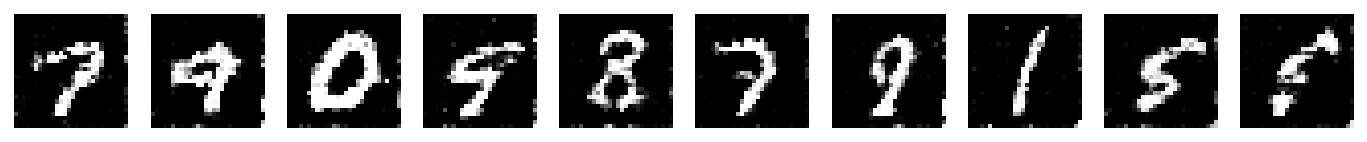

165 epoch  genloss: 87.76018571853638 disloss: 79.42446255683899


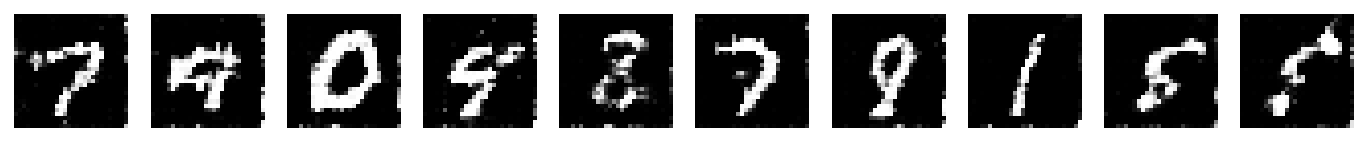

170 epoch  genloss: 87.88953918218613 disloss: 79.52230870723724


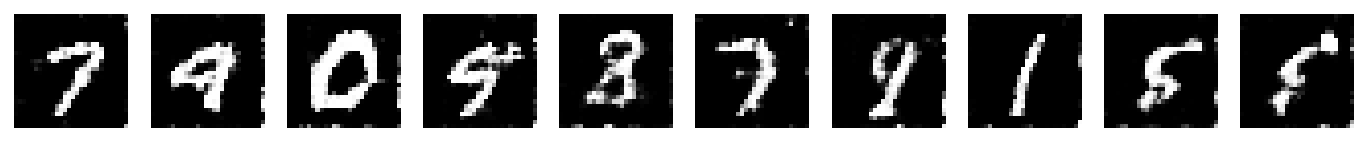

175 epoch  genloss: 87.53836125135422 disloss: 79.73248434066772


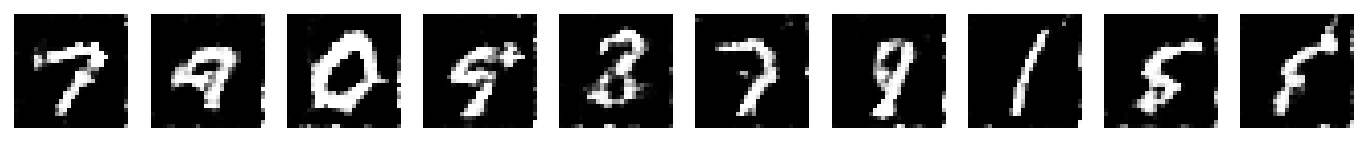

180 epoch  genloss: 87.12694358825684 disloss: 79.94445037841797


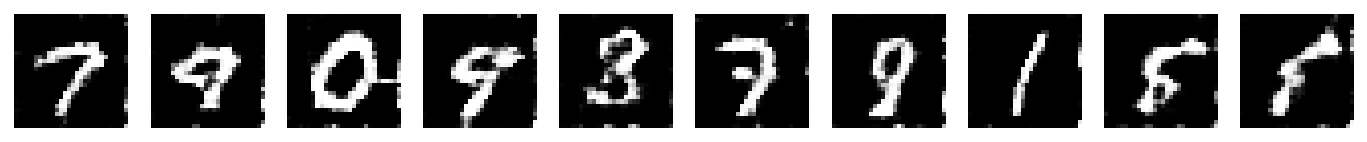

185 epoch  genloss: 87.06984347105026 disloss: 79.95867109298706


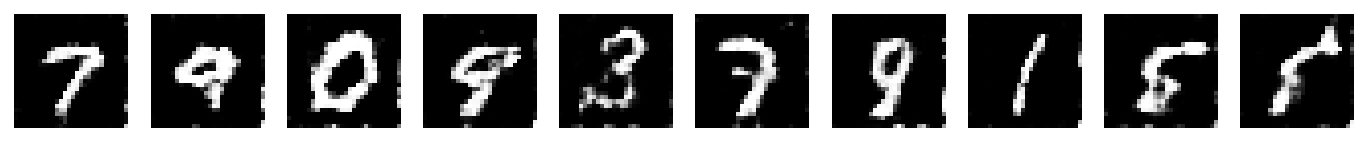

190 epoch  genloss: 86.71607965230942 disloss: 80.0299801826477


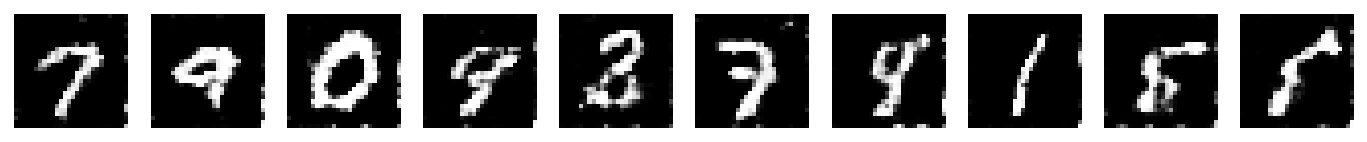

195 epoch  genloss: 86.89839959144592 disloss: 79.9531301856041


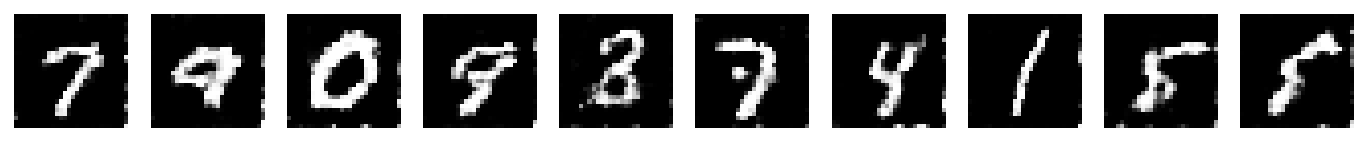

200 epoch  genloss: 86.7284324169159 disloss: 80.07889527082443


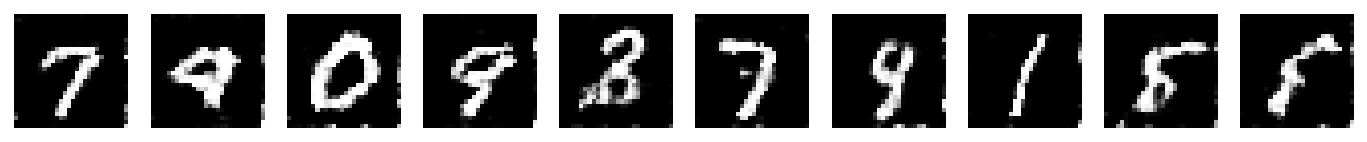

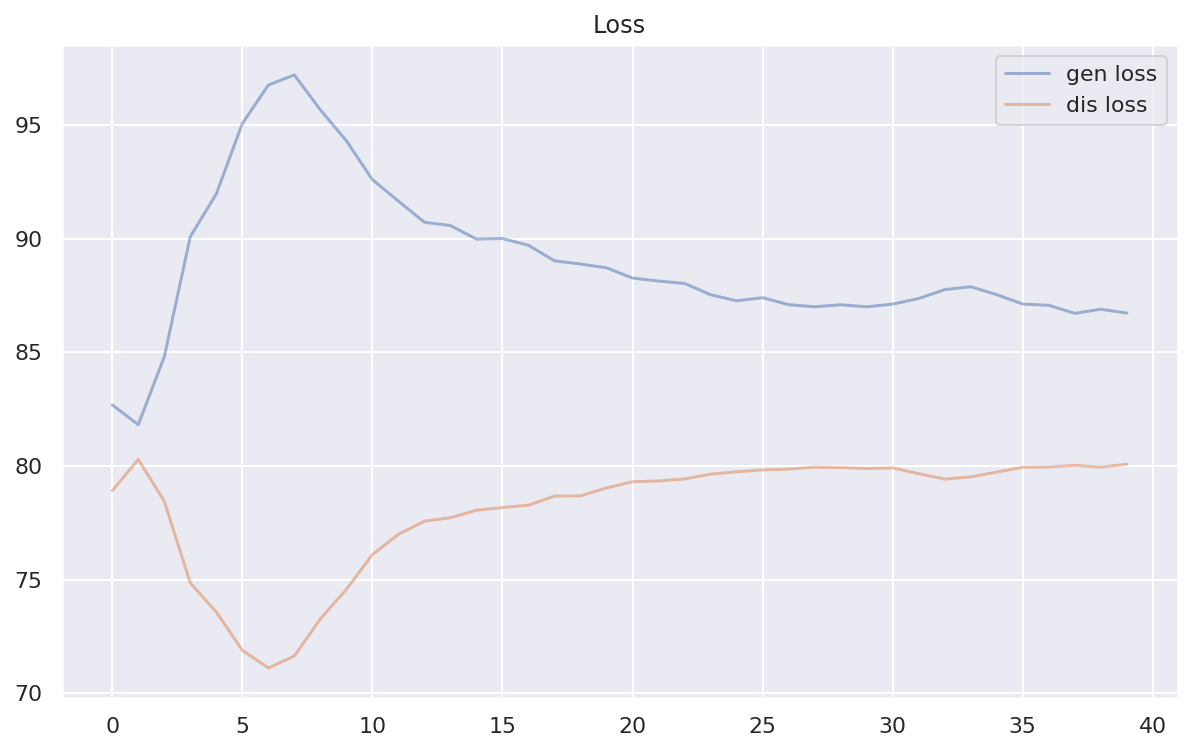

CPU times: user 11min 13s, sys: 1min 27s, total: 12min 41s
Wall time: 30min 24s


In [8]:
%%time

zeros = try_gpu(torch.zeros(1000))
ones = try_gpu(torch.ones(1000))
generator.train()
discriminator.train()

gen_losses = []
dis_losses = []
fix_images = []
num_epoch = 200
for epoch in range(1, num_epoch+1):
    gen_loss = 0.0
    dis_loss = 0.0
    for images, labels in trainloader:
        batch_len = len(images)
        images, labels = try_gpu(images), try_gpu(labels)

        # 偽画像を作る
        z = try_gpu(torch.randn(batch_len, z_dim))
        fake_images = generator(z)

        # 偽画像の Tensor から勾配情報を抜いたものを discriminator の学習のために保存
        fake_images_ = fake_images.detach()

        # generatorの学習
        fake_out = discriminator(fake_images)
        g_l = criterion(fake_out, ones[:batch_len]) # fakeが正解
        generator.zero_grad(), discriminator.zero_grad()
        g_l.backward()
        gen_optimizer.step()
        gen_loss += g_l.item()

        # discriminatorの学習
        # Pytorchは同じTensorに対して2回backwardできないのでfake_images_を使う
        fake_out = discriminator(fake_images_)
        real_out = discriminator(images)
        d_l_f = criterion(fake_out, zeros[:batch_len]) # fake は誤り
        d_l_r = criterion(real_out, ones[:batch_len])
        d_l = (d_l_f + d_l_r) / 2   # 2で割るのはg_lとスケールを合わせるため
        generator.zero_grad(), discriminator.zero_grad()
        d_l.backward()
        dis_optimizer.step()
        dis_loss += d_l.item()

    print_per = 5
    if epoch % print_per == 0:
        gen_loss_mean = gen_loss
        dis_loss_mean = dis_loss
        print(f'{epoch} epoch  genloss: {gen_loss_mean} disloss: {dis_loss_mean}' , flush=True)
        gen_losses.append(gen_loss_mean)
        dis_losses.append(dis_loss_mean)

        # fix image generatorにかける
        generator.eval()
        discriminator.eval()
        with torch.no_grad():
            fix_image = generator(fix_z).squeeze().cpu()
            plt.figure(figsize=(12, 2))
            for i, img in enumerate(fix_image, start=1):
                plt.subplot(1, 10, i)
                plt.imshow(img, cmap="gray")
                plt.axis("off")
            plt.show()
            fix_images.append(fix_image)

        generator.train()
        discriminator.train()


plt.figure(figsize=(10, 6))
plt.plot(gen_losses, alpha=0.5, label="gen loss")
plt.plot(dis_losses, alpha=0.5, label="dis loss")
plt.legend()
plt.title("Loss")
plt.show()

### 適当な乱数で大量に画像生成してみる

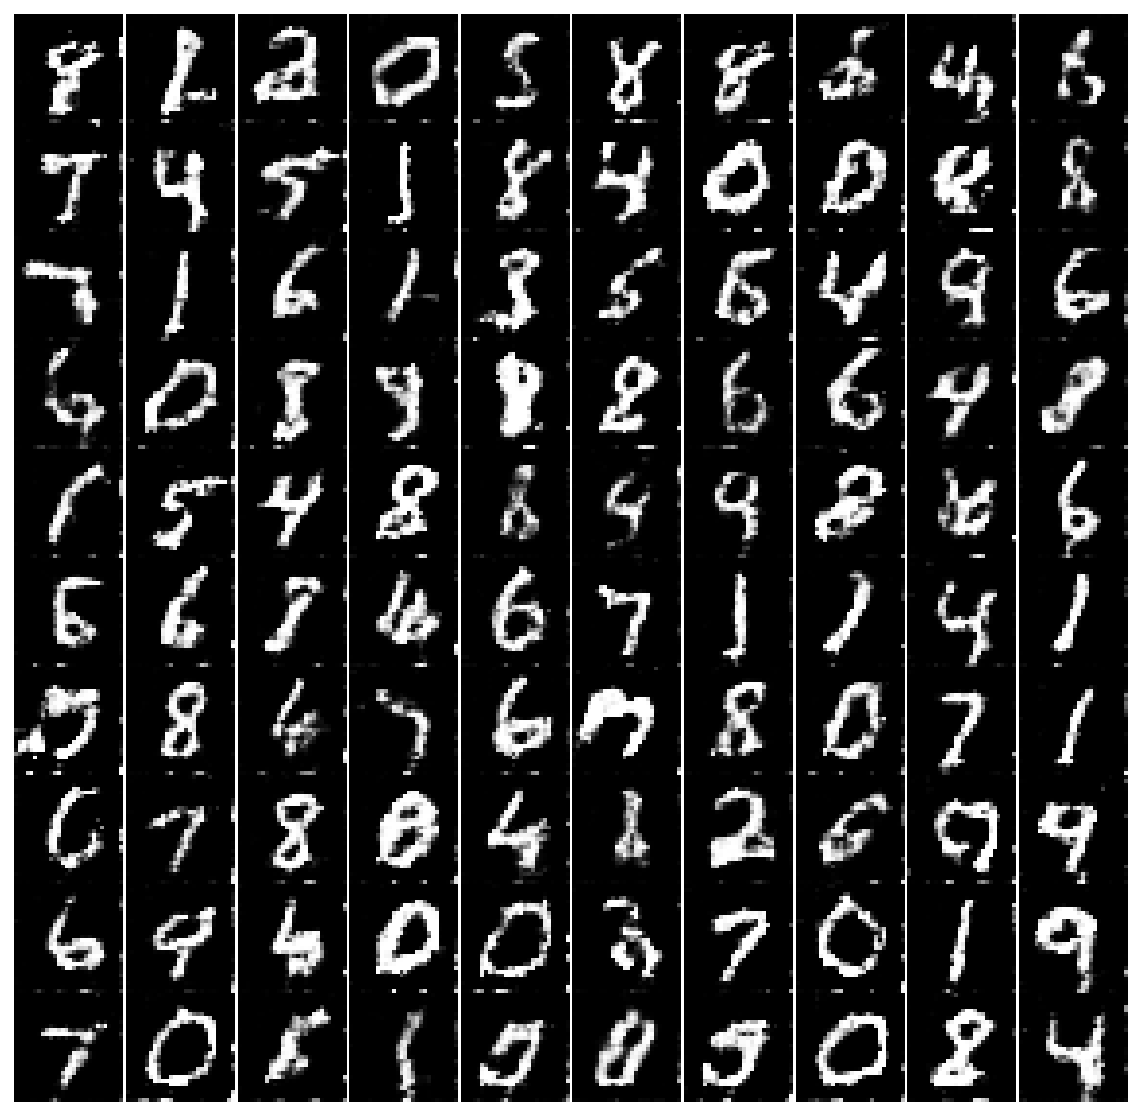

CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


In [13]:
%%time
generator.eval()
discriminator.eval()
with torch.no_grad():
    rand = try_gpu(torch.randn(100, z_dim))
    fake_images = generator(rand).squeeze().cpu()

    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, img in enumerate(fake_images, start=1):
        plt.subplot(10, 10, i)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
    plt.show()